In [2]:
pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 28.6 MB/s eta 0:00:00


## Extracción del texto

In [3]:
import fitz

In [4]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

pdf_path = "./fiodor.pdf"
raw_text = extract_text_from_pdf(pdf_path)


In [5]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n+', '\n', text)  # Unifica saltos de línea
    text = re.sub(r'\s+', ' ', text)  # Elimina espacios extras
    text = re.sub(r'\d+\s*', '', text)  # Elimina números de página u otros
    text = text.strip()
    return text

cleaned_text = clean_text(raw_text)

In [6]:
cleaned_text[:1000]

'crimen y castigo por fedor mikhaïlovitch dostoïevski parte capítulo una tarde extremadamente calurosa de principios de julio, un joven salió de la reducida habitación que tenía alquilada en la callejuela de s y, con paso lento e indeciso, se dirigió al puente k. había tenido la suerte de no encontrarse con su patrona en la escalera. su cuartucho se hallaba bajo el tejado de un gran edificio de cinco pisos y, más que una habitación, parecía una alacena. en cuanto a la patrona, que le había alquilado el cuarto con servicio y pensión, ocupaba un departamento del piso de abajo; de modo que nuestro joven, cada vez que salía, se veía obligado a pasar por delante de la puerta de la cocina, que daba a la escalera y estaba casi siempre abierta de par en par. en esos momentos experimentaba invariablemente una sensación ingrata de vago temor, que le humillaba y daba a su semblante una expresión sombría. debía una cantidad considerable a la patrona y por eso temía encontrarse con ella. no es que 

# Predecir el siguiente caracter

## Crear secuencias de texto para entrenamiento
Necesitamos convertir el texto en secuencias que la red LSTM pueda usar. Por ejemplo, para cada 40 caracteres, predecir el siguiente.

In [ ]:
seq_length = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(cleaned_text) - seq_length, step):
    sentences.append(cleaned_text[i: i + seq_length])
    next_chars.append(cleaned_text[i + seq_length])


In [ ]:
sentences[:10]

['crimen y castigo por fedor mikhaïlovitch',
 'men y castigo por fedor mikhaïlovitch do',
 ' y castigo por fedor mikhaïlovitch dosto',
 'castigo por fedor mikhaïlovitch dostoïev',
 'tigo por fedor mikhaïlovitch dostoïevski',
 'o por fedor mikhaïlovitch dostoïevski pa',
 'or fedor mikhaïlovitch dostoïevski parte',
 'fedor mikhaïlovitch dostoïevski parte ca',
 'or mikhaïlovitch dostoïevski parte capít',
 'mikhaïlovitch dostoïevski parte capítulo']

In [ ]:
 next_chars[:10]

[' ', 's', 'ï', 's', ' ', 'r', ' ', 'p', 'u', ' ']

## Vectorizar el texto
Convertimos los caracteres a vectores one-hot.

In [ ]:
import numpy as np
chars = sorted(list(set(cleaned_text)))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

X = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool_)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


In [ ]:
X.shape

(403279, 40, 56)

In [ ]:
X[0][0:3][:]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, Fa

## Crear el modelo LSTM en Keras

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')


2025-04-07 14:55:54.308131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
//anaconda3/envs/tareaDL/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        94,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 56)             │         7,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,944 (398.22 KB)

 Trainable params: 101,944 (398.22 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenar

In [ ]:
model.fit(X, y, batch_size=128, epochs=20)


Epoch 1/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 144s 45ms/step - loss: 2.5489
Epoch 2/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 126s 40ms/step - loss: 1.9590
Epoch 3/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 126s 40ms/step - loss: 1.8139
Epoch 4/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 126s 40ms/step - loss: 1.7083
Epoch 5/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 128s 41ms/step - loss: 1.6320
Epoch 6/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 129s 41ms/step - loss: 1.5761
Epoch 7/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 129s 41ms/step - loss: 1.5241
Epoch 8/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 130s 41ms/step - loss: 1.4872
Epoch 9/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 131s 42ms/step - loss: 1.4590
Epoch 10/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 133s 42ms/step - loss: 1.4324
Epoch 11/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 154s 49ms/step - loss: 1.4050
Epoch 12/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 161s 51ms/step - loss: 1.3910
Epoch 13/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 167s 53ms/step - loss: 1.3695
Epoch 14/20
3151/3151 ━━━━━━━━━━━━━━━━━━━━ 155s 49ms/step - 

In [ ]:
model.save("./lstm1.keras")

In [ ]:
len(chars)

56

In [ ]:
frase = "quiero encontrar algo que valga la pena "
print(len(frase))

40


In [ ]:
def autoregresion(frase_inicial):
    frase_oh = np.zeros((seq_length, len(chars)), dtype=np.bool_)
    for t, char in enumerate(frase_inicial):
        frase_oh[t, char_indices[char]] = 1
    frase_oh = np.expand_dims(frase_oh,axis = 0)
    result = model.predict(frase_oh)
    return indices_char[np.argmax(result[0])]

In [ ]:
pred_word = ""
for i in range(5):
    nueva_letra = autoregresion(frase)
    print(nueva_letra)
    frase = frase[1:]
    frase+= nueva_letra
    pred_word+= nueva_letra
print(pred_word)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
i
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
o
aia o


# Predecir el siguiente token

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
tokenizer = Tokenizer(num_words=limit_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts([cleaned_text])

# Secuencia entera de tokens
sequence = tokenizer.texts_to_sequences([cleaned_text])[0]
#vocab_size = len(tokenizer.word_index) + 1  # +1 por el token 0
limit_vocab = int(len(tokenizer.word_index)*0.3)
vocab_size = limit_vocab +1

In [31]:
print("vocab_size: ",vocab_size)
print("tokenizer.word_index: ",len(tokenizer.word_index))
print("tamaño sequence: ",len(sequence))

vocab_size:  5811
tokenizer.word_index:  19368
tamaño sequence:  206322


In [32]:
import numpy as np

sequence_sample = sequence[:int(len(sequence)*0.1)]

seq_length = 5  # número de tokens de entrada
X = []
y = []

for i in range(seq_length, len(sequence_sample)):
    input_seq = sequence_sample[i - seq_length:i]
    target = sequence_sample[i]
    X.append(input_seq)
    y.append(target)

X = np.array(X)
y = np.array(y)


In [ ]:
# Convertir etiquetas a one-hot
#from tensorflow.keras.utils import to_categorical
#y = to_categorical(y, num_classes=vocab_size)

## Modelo

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

modelo = Sequential()
modelo.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=seq_length))
modelo.add(LSTM(64))
modelo.add(Dense(vocab_size, activation='softmax'))

modelo.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelo.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
print(X.shape, y.shape)

(20627, 5) (20627,)


## Entrenamiento


In [35]:
history = modelo.fit(X, y, epochs=30,batch_size=16, verbose=1)

Epoch 1/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.0899 - loss: 6.7454
Epoch 2/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.0941 - loss: 5.8890
Epoch 3/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.1039 - loss: 5.7118
Epoch 4/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.1109 - loss: 5.5704
Epoch 5/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.1159 - loss: 5.3720
Epoch 6/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.1273 - loss: 5.1898
Epoch 7/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.1393 - loss: 5.0012
Epoch 8/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.1503 - loss: 4.7878
Epoch 9/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.1647 - loss: 4.5754
Epoch 10/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.1774 - loss: 4.3821
Epoch 11/30
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.1940 - loss: 4.2031
Epoch 12

In [47]:
modelo.save("./lstm_words1.keras")

In [24]:
import random

def generate_text(seed_text, n_words, tokenizer, seq_length):
    result = []
    in_text = seed_text

    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = encoded[-seq_length:]  # asegurarse de que tenga el tamaño correcto
        padded = np.pad(encoded, (seq_length - len(encoded), 0), 'constant')
        padded = padded.reshape(1, -1)

        y_pred = modelo.predict(padded, verbose=0)
        predicted = np.argmax(y_pred)

        out_word = tokenizer.index_word.get(predicted, '')
        in_text += ' ' + out_word
        result.append(out_word)

    return ' '.join(result)


frase cualquiera para probar

In [36]:
seed = "el hombre miró al"
print(generate_text(seed, 20, tokenizer, seq_length=5))


lado <OOV> <OOV> a cobrar la solicitud de su <OOV> la esposa para <OOV> en un <OOV> <OOV> y hacía


Una frase del texto: "Su cuartucho se hallaba"

In [45]:
seed = "Su cuartucho se hallaba"
print(generate_text(seed, 20, tokenizer, seq_length=5))

bajo el <OOV> de <OOV> si no se propone gracias a su influencia sobre su futuro esposo influencia que no


acierta en las dos primeras palabras "bajo" y "el"

In [37]:
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


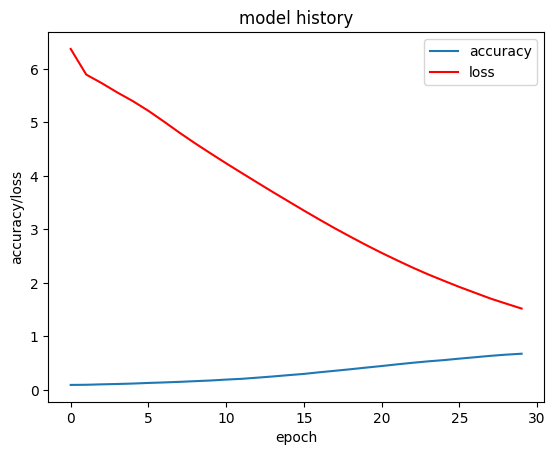

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label= "accuracy")
plt.plot(history.history['loss'],label = "loss",color="red")
plt.title('model history')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

new_model.summary()

loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_images).shape)